# Imports

In [1]:
# Imports
import os
from datetime import timedelta
from logging import INFO, basicConfig, info
from time import time

from numpy import argmax
from sklearn.model_selection import train_test_split as split
from torch import device as Device
from torch.backends.mps import is_available as mps_available
from torch.cuda import is_available as cuda_available
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

# from segmentation_models_pytorch import Unet
# from src.models.vitnet import VitNet
from src.models.unet import Unet
from src.utils.dataset import ForestDataset
from src.utils.loss import loss
from src.utils.misc import seed
from src.utils.models import evaluation, load, save, training
from src.utils.plots import plot_image_and_prediction
from src.utils.predictions import predict_image, predict_patch
from src.utils.preprocessing import Preprocessor
from src.utils.sampling import compute_sampling_weights

# Global parameters

In [2]:
patch_size = 256
img_dir = "data/images"
log_dir = "logs"
model_dir = "models"
patch_dir = f"data/patches/{patch_size}"
patches_file = f"data/patches/{patch_size}/info.fth"
gedi_file = "data/gedi/gedi_complete.fth"
random_state = 42
batch_size = 12
num_workers = 6
learning_rate = 1e-2
epochs = 1
is_training = True
bins = list(range(0, 55, 5))
device = Device("cuda" if cuda_available() else "mps" if mps_available() else "cpu")

seed(random_state)

basicConfig(level=INFO)

info(f"Using {device} device")

INFO:root:Using mps device


# Preprocess labels and patches

In [3]:
# Create preprocessor
preprocessor = Preprocessor(patches_file, img_dir, patch_dir, gedi_file, patch_size)

# Run preprocessor
preprocessor.run()

# Get labels
labels = preprocessor.gedi.rh98

# Get patches
patches = preprocessor.patches

info(f"Total number of patches: {len(patches)}")

INFO:root:Starting preprocessing...
INFO:root:Directories validated.
INFO:root:Images loaded.
INFO:root:Number of images: 48
INFO:root:GEDI data loaded.
INFO:root:Loaded existing patch info file. Skipping image processing.
INFO:root:Number of patches: 9234
INFO:root:Number of labels: 629074
INFO:root:Total number of patches: 9234


<Axes: >

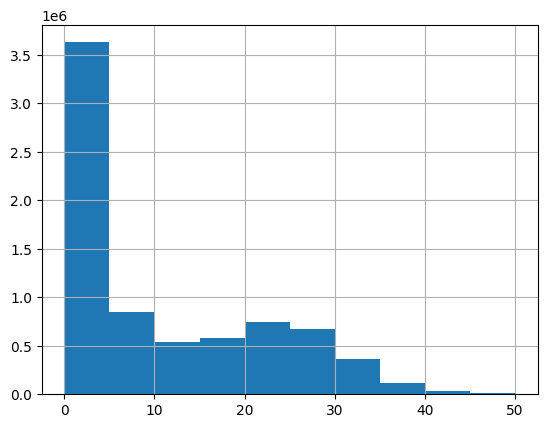

In [4]:
# Plot histogram of labels
labels.hist(bins=bins)

# Create datasets & dataloader

In [5]:
# Create stratification
stratify = patches.bins.apply(argmax)

# Split patches
train, rest = split(
    patches, test_size=0.3, random_state=random_state, stratify=stratify
)

# Create stratification for rest
stratify = stratify[patches.index.isin(rest.index)]

# Split rest
val, test = split(rest, test_size=0.5, random_state=random_state, stratify=stratify)

# Create datasets
traindata = ForestDataset(train, patch_dir)
valdata = ForestDataset(val, patch_dir)
testdata = ForestDataset(test, patch_dir)

# Create weighted sampler
weights = compute_sampling_weights(train, labels, bins)
sampler = WeightedRandomSampler(weights, len(train))

# Create dataloaders
trainloader = DataLoader(traindata, batch_size, False, sampler, num_workers=num_workers)
valloader = DataLoader(valdata, batch_size, False, num_workers=num_workers)
testloader = DataLoader(testdata, batch_size, False, num_workers=num_workers)

# Create & Train model

In [6]:
# model = VitNet().to(device)

# Initialise model
model = Unet().to(device)

model_file = os.path.join(model_dir, f"m-{model.name}-p{patch_size}-e{epochs}.pt")

info(model)

if is_training:
    # Create optimizer
    optimizer = Adam(model.parameters(), learning_rate)

    # Create scheduler
    scheduler = CosineAnnealingLR(optimizer, epochs)

    # Create writer
    writer = SummaryWriter(log_dir)

    # images, _ = next(iter(trainloader))

    # writer.add_images("images", images[:, :3, :, :].to(device))
    # writer.add_graph(model, images.to(device))

    start = time()

    # Training loop
    for epoch in range(epochs):
        training(trainloader, model, loss, device, writer, epoch, optimizer)
        evaluation(valloader, model, loss, device, writer, epoch)
        scheduler.step()

    end = time()

    writer.close()

    info(f"Training completed in {timedelta(seconds=(end - start))}")

    score = evaluation(testloader, model, loss, device)

    info(f"Final loss on test set: {score}")

    info(f"Saving model {model.name}")

    # Save model
    save(model, model_file)
else:
    info(f"Loading model {model.name}")

    # Load model
    model = load(
        model,
        model_file,
        device,
    )

INFO:root:Unet(
  (down_conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_conv3): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_conv4): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace

# Visualise results

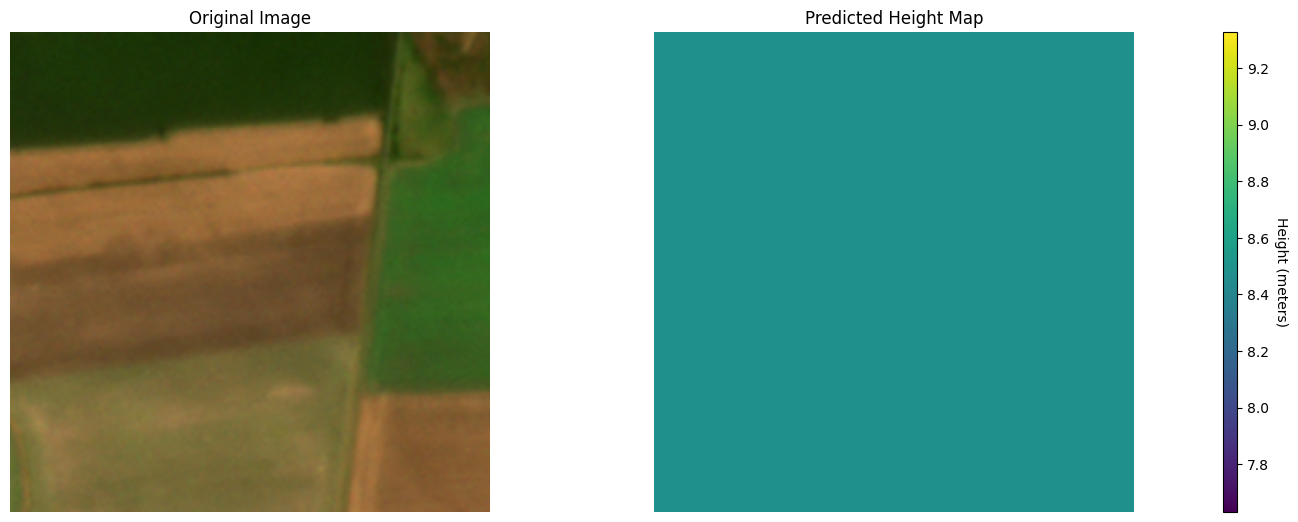

In [7]:
idx = 42
patch = testdata[idx]
img, pred = predict_patch(model, patch, device)
plot_image_and_prediction(img, pred, 3)

In [8]:
image, prediction = predict_image(
    model, device, f"{img_dir}/L15-1059E-1348N.tif", patch_size
)

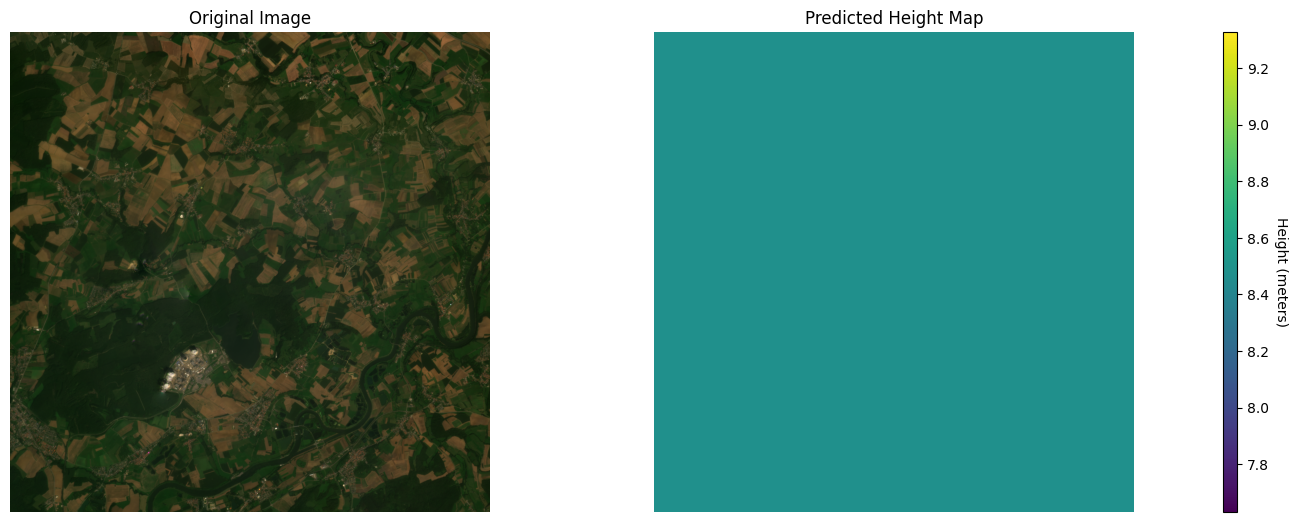

In [9]:
plot_image_and_prediction(image, prediction, 3)

In [10]:
# save_prediction(prediction, os.path.join("results", "L15-1059E-1348N-P.tiff"))